# IMPACT OF COVID-19 ON DIGITAL LEARNING IN THE UNITED STATES
The COVID-19 pandemic has posed profound challenges for students by upending schools and campuses and disrupting learning in the United States.Though schools have attempted to reach students through distance learning tools,it has deepened the pre-existing disparities in educational opportunity and outcomes.This analysis attempts to uncover trends in digital learning.

















In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## <span style="color:green">**OVERVIEW OF DATA** </span>

The following three datasets have been provided for analysis:
1. Product Information Data - products_info.csv
2. District Information Data - district_info.csv
3. Engagement_data 



> <span style="color:maroon">**PRODUCT INFORMATION DATA** </span>

The products_info is a csv file consisting of information about the characteristics of the top 372 products with most users in 2020.

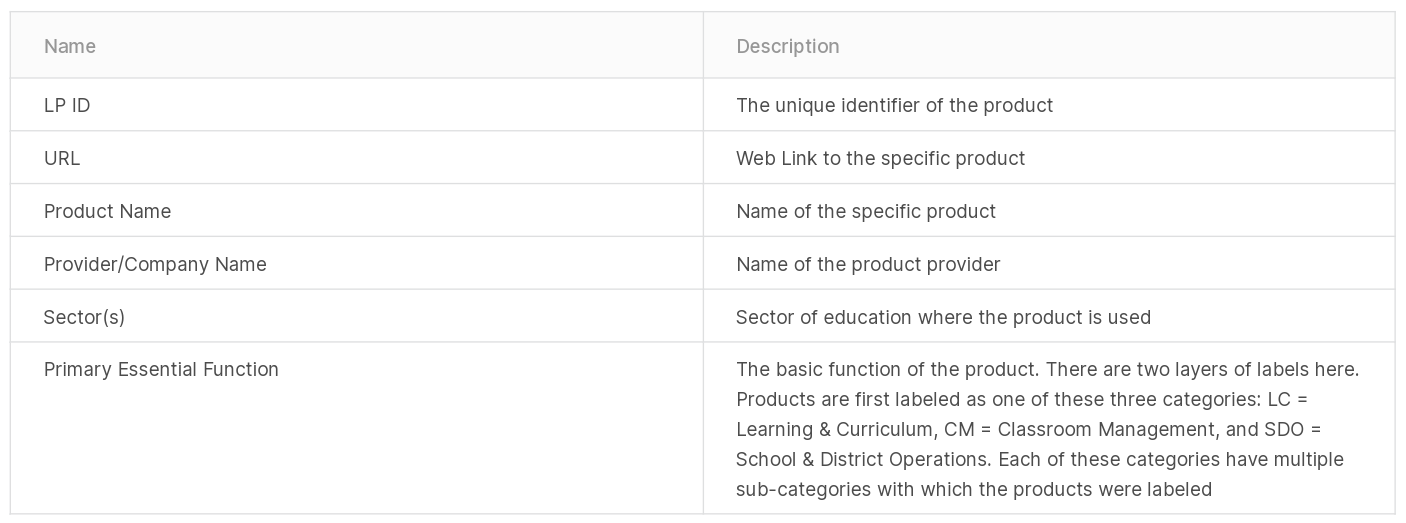


In [ ]:
#Importing the product information data
product_data = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")
product_data.head(5)

In [ ]:
product_data.dtypes

In [ ]:
product_data.nunique()

In [ ]:
product_data["Sector(s)"].value_counts()

In [ ]:
product_data["Primary Essential Function"].value_counts()

In [ ]:
product_data.isnull().sum()

*****Summary*****
* Product Information Data consists of 327 unique products with unique ids,names and URLs.
* Sector(s) of education where the product is used is divided into 5 unique categories
             > PreK-12                          
             > PreK-12; Higher Ed; Corporate    
             > PreK-12; Higher Ed                
             > Corporate                          
             > Higher Ed; Corporate               

* There are 290 Provider/Companies to which the 372 products belong - Companies like Google and Microsoft have more products than the others
* The Primary Essential functions are divided into 35 unique categories.Each of each fall under one of the following categories of  
             > LC = Learning & Curriculum, 
             > CM = Classroom Management, and 
             > SDO = School & District Operations 
and then further divided into subcategories.
* Most products have the primary essential function of LC - Digital Learning Platforms
* Primary Essential Function and Sector(s) columns contain 20 null values where as Provider/Company Name consists of i null value 

> <span style="color:maroon">**DISTRICT INFORMATION DATA** </span>

The districts_info is a csv file containing information about the characteristics of school districts. 
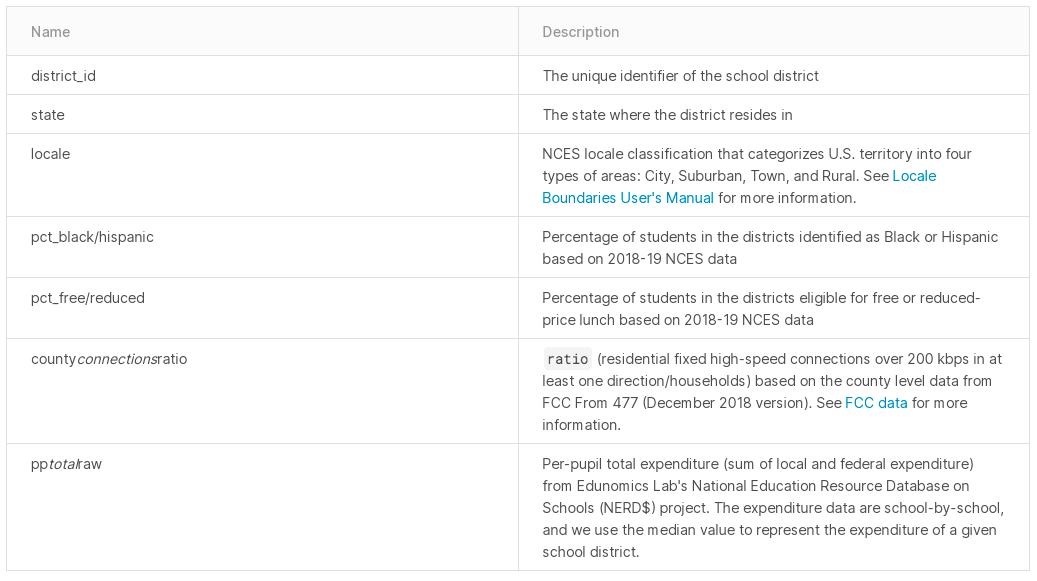

In [ ]:
#importing the district info data
district_data = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")
district_data.head(5)

In [ ]:
district_data.dtypes

In [ ]:
district_data.nunique()

In [ ]:
district_data["locale"].value_counts()

In [ ]:
district_data.isnull().sum()

*****Summary*****
* District Information Data consists of information about 233 district school districts 
* These school districts belong to 23 states.Hence all the states are not covered here.
* Majority school districts belong to suburb locale


> <span style="color:maroon">**ENGAGEMENT DATA** </span>

The engagement_data folder consists of 233 csv files with each file representing data from one school district. The 4-digit file name represents district_id.The engagement data are based on LearnPlatform’s Student Chrome Extension. The extension collects page load events of over 10K education technology products in their product library, including websites, apps, web apps, software programs, extensions, ebooks, hardwares, and services used in educational institutions. 


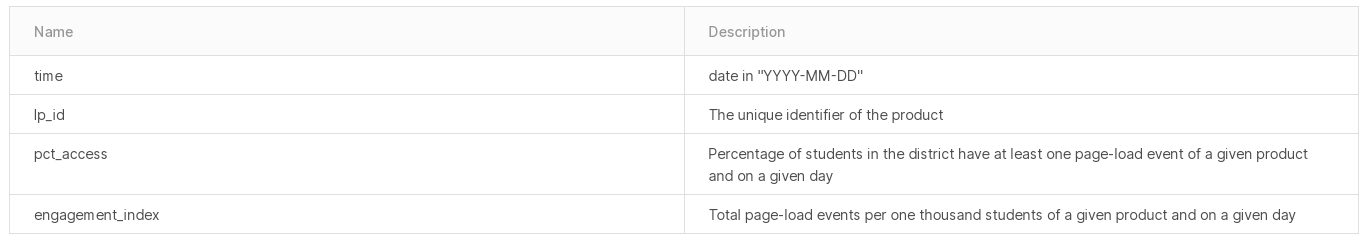



The 4-digit file names is the engagement_data folder represent district_id which can be used to link to district information in district_info.csv. The lp_id can be used to link to product information in product_info.csv.

All the csv files in the engagement_data folder have to be concatenated into one dataframe.We will also add a new column named district_id which will be the filename denoting the district ids from where the engagement data belongs

In [ ]:
#Concatenating all the csv files in engagement_data folder and assigning a new column with district_id
from glob import glob
stock_file = sorted(glob("../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/*.csv"))
eng_data = pd.concat((pd.read_csv(file).assign(filename=file[-8:-4])
          for file in stock_file),ignore_index = True)

In [ ]:
#Changing filename to district_id and setting distict_id as the index
eng_data.rename(columns = {"filename":"district_id"},inplace = True)

In [ ]:
eng_data.isnull().sum()

In [ ]:
eng_data["lp_id"].nunique()

*****Summary*****
* Engagement data consists of 8646 unique lp_ids.However,we have product description for only 372 lp_ids in our product information data
* lp_id column has 541 null values which have to be dealt with because lp_id will be the key to merge engagement data to product data

## <span style="color:green">**DATA PREPARATION** </span>

> <span style="color:maroon">**PRODUCT INFORMATION DATA** </span>

Steps to clean the product Information Data
    
1. Dropping the URL column because it is unique for each product and is irrelevant
    in our analysis
2. Renaming the column LP ID to lp_id and Changing the data type of lp_id to string.
3. Handling Missing Data
4. Splitting the Primary Essential Function column





**1. Dropping the URL column because it is unique for each product and is irrelevant in our analysis**

In [ ]:
#Dropping columns URL,Company Name,Sector(s)
product_data.drop("URL",axis = 1,inplace = True)

**2. Renaming the column LP ID to lp_id and changing the data type of lp_id to string**

LP ID is the key that links the product information data to the engagement data. Renaming it to lp_id(as named in the engagement data) will add consistency.

In [ ]:
# Renaming LP ID to lp_id
product_data.rename(columns = {"LP ID":"lp_id"},inplace = True)
product_data = product_data.astype({"lp_id":str})

**3. Handling Missing Data**

In [ ]:
product_data.isnull().sum()

There are 20 products for which Primary Essential Function is not given.However,dropping these data points might lead to vital information loss.Hence we will fill the null values in the Primary Essential function to "Unknown-Unknown" instead of dropping the whole data point.

There is one product for which the Provider/Company Name is a null value.We will fill this null value to "Not Given"

In [ ]:
#filling missing values
product_data["Primary Essential Function"].fillna("Unknown-Unknown",inplace=True)
product_data["Provider/Company Name"].fillna("Not Given",inplace=True)

**4. Splitting the Primary Essential Function**
Splitting the Primary essential function column into two columns to display both the layers of the label.We will name the columns Function-Category and Function-Subcategory.

In [ ]:
#Split the Primary Essential Function
def category(string):
    x = string.split("-")
    return x[0]

def subcat(string):
    x = string.split("-",1)
    return x[1]

product_data["Function-Category"]=product_data["Primary Essential Function"].apply(category)
product_data["Function-Sub-Category"]=product_data["Primary Essential Function"].apply(subcat)

In [ ]:
product_data.head()

> <span style="color:maroon">**DISTRICT INFORMATION DATA** </span>


1. Handling Missing Values
2. Converting district_id to string
3. Dropping column "county_connection_ratio"

**Handling Missing Values**

There are 57 data points for which all the column values except the district id are null values.These data points are of no significance to us and can be dropped as they would not add to our analysis



In [ ]:
district_data.isnull().sum()

In [ ]:
district_data.dropna(axis=0,subset=["state"],inplace=True)


**2. Converting district_id to string data type**


In [ ]:
district_data = district_data.astype({"district_id":str})

**3. Dropping column county_connections_ratio**


In [ ]:
#Dropping column county_connections_ratio
district_data.drop("county_connections_ratio",axis = 1,inplace = True)

> <span style="color:maroon">**ENGAGEMENT DATA** </span>

We will be doing the following steps to clean the engagement Data
1. Handling Missing Values - Dropping the rows with missing lp_id values
[2. Converting lp_id to int and then to string](http://)



**1. Handling Missing Values** - Dropping the rows with missing lp_id values

In [ ]:
#Dropping rows with missing "lp_id"
eng_data.dropna(axis = 0,subset=["lp_id"],inplace = True)
eng_data.isnull().sum()

**2. Converting lp_id to int and then to str**


In [ ]:
#COnverting lp_id to int and then to str
eng_data = eng_data.astype({"lp_id":int})


In [ ]:
eng_data = eng_data.astype({"lp_id":str})

> <span style="color:maroon">**MERGING THE DATASETS** </span>

In [ ]:
# Merging engagement data and product data on key "lp_id"
product_eng_data = pd.merge(product_data,eng_data,how = "outer",on = "lp_id")
# Merging data with district data on key "district_id"
product_eng_data = pd.merge(product_eng_data,district_data,how="outer",on="district_id")


In [ ]:
product_eng_data["lp_id"].nunique()

After merging the dataframes,we can see that there are 8649 unique lp_ids (product ids).However, we have product description for only 372 product ids.Hence in order to analyze the student engagement with different types of education technology products in the Learn Platform library,we will drop the rows for which product description is not given. We will also drop the rows with null engagement index.

The district_data has information about 176 unique districts.However after merging the datasets,there are 233 unique district_ids in the dataframe.We will drop the rows with the extra 57 district ids.Moreover, we will also drop the rows for which pct_free/reduced is a null value.We will fill the null values for pp_total_raw to zero,as these may be the districts that didnot receive the per-pupil total expenditure.
 

**Dropping rows where Product Name,engagement index,state,pct_free/reduced are null value**

In [ ]:
#Dropping rows for which product description and engagement index is not given in the product_data dataframe
product_eng_data.dropna(axis = 0,subset=["Product Name","engagement_index","state","pct_free/reduced"],inplace=True)



**Filling null values for the pp_total_raw to zero**

In [ ]:
product_eng_data["pp_total_raw"].fillna(0,inplace=True)

In [ ]:
product_eng_data.shape

## <span style="color:green">**EXPLORATORY DATA ANALYSIS** </span>

> <span style="color:maroon">**DESCRIPTION OF PRODUCTS IN THE LEARN PLATFORM LIBRARY** </span>

In [ ]:
#Finding out the function category and subcategory that most products belong to
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,30))

plt.subplot(3,1,1)
plt.title("Figure 1 - NUMBER OF PRODUCTS IN EACH FUNCTION-CATEGORY",fontsize = 25)
plt.xlabel("Function-Category",fontsize=20)
plt.ylabel("Number Of Products",fontsize=20)
sns.countplot(x="Function-Category",data = product_data)

plt.subplot(3,1,2)
plt.title("Figure 2 - NUMBER OF PRODUCTS IN EACH FUNCTION-SUB-CATEGORY",fontsize = 25)
plt.xlabel("Function-Sub-Category",fontsize=20)
plt.ylabel("Number Of Products",fontsize=20)
plt.xticks(rotation = 90)
sns.countplot(x="Function-Sub-Category",data=product_data)


product_data_company=product_data.groupby("Provider/Company Name").count().sort_values("Product Name",ascending=False).head(5)
product_data_company["Provider/Company Name"]=product_data_company.index
plt.subplot(3,1,3)
plt.title("Figure 3 - TOP 5 PROVIDER/COMPANY WITH MOST PRODUCTS",fontsize = 25)
plt.xlabel("Provider/Company Name",fontsize=20)
plt.ylabel("Number Of Products",fontsize=20)
sns.barplot(x="Provider/Company Name",y = "Product Name",data=product_data_company)


plt.tight_layout()

*****Observations*****

1. Maximum number of products in the product information data fall under the category of LC 

2. Maximum number of products in the product information data fall under the subcategory of Digital Learning Platforms

3. Google LLC has the maximum number of products,followed by Microsoft, Houghton Mifflin Harcourt, Learning A- Z and IXL Learning

> <span style="color:maroon">**STUDENT ENGAGEMENT WITH DIFFERENT TYPES OF EDUCATION TECHNOLOGY - BY FUNCTION**</span>


In [ ]:
#Student engagement with types of education technology - top 6

edtech_eng = product_eng_data.groupby("Function-Sub-Category").mean()
edtech_eng_top6 = edtech_eng.sort_values(["engagement_index"],ascending=False).head(6)
edtech_eng_top6["Function-Sub-Category"]=edtech_eng_top6.index

plt.figure(figsize = (15,8))
plt.title("Figure 4 - TOP 6 FUNCTIONS",fontsize=25)
sns.barplot(x = "engagement_index",y ="Function-Sub-Category",data = edtech_eng_top6)
plt.xlabel("engagement_index",fontsize=15)
plt.ylabel("Function-Sub-Category",fontsize=15)


plt.tight_layout()

*****Observations*****

Among the top 6 functions,Learning Management Systems witnessed the highest student engagement followed by Online Course Providers & Technical Development.



> <span style="color:maroon">**STUDENT ENGAGEMENT WITH PRODUCTS BELONGING TO LEARNING MANAGEMENT SYSTEM CATEGORY**</span>

In [ ]:
product_eng_product_LMS=product_eng_data[product_eng_data["Primary Essential Function"]=="SDO - Learning Management Systems (LMS)"]
plt.figure(figsize=(15,8))
plt.title("Figure-5",fontsize=25)
sns.barplot(x="engagement_index",y="Product Name",data=product_eng_product_LMS)
plt.xlabel("engagement_index",fontsize=15)
plt.ylabel("Products under SDO - Learning Management Systems (LMS)",fontsize=15)


plt.tight_layout()

*****Observations*****

Under Learning Management Systems category,Google Classrooms has the maximum engagement.

> <span style="color:maroon">**MONTH-WISE ANALYSIS OF STUDENT ENGAGEMENT - BY TOP 6 FUNCTIONS**</span>

In [ ]:
import datetime
product_eng_data["Month"]=pd.DatetimeIndex(product_eng_data['time']).month_name()

product_eng_data["Month Num"]=pd.DatetimeIndex(product_eng_data['time']).month
list1 = ["SDO - Learning Management Systems (LMS)","LC - Online Course Providers & Technical Skills Development","LC - Content Creation & Curation"]
list2 = ["CM - Virtual Classroom - Video Conferencing & Screen Sharing","CM - Classroom Engagement & Instruction - Assessment & Classroom Response","SDO - School Management Software - SSO"]
list3 = ["CM - Virtual Classroom - Video Conferencing & Screen Sharing"]

filt1 = product_eng_data["Primary Essential Function"].isin(list1)
edtech_eng_time1 = product_eng_data[filt1]
edtech_eng_time1 = edtech_eng_time1.groupby(["Month Num","Month","Function-Sub-Category"]).mean()

filt2 = product_eng_data["Primary Essential Function"].isin(list2)
edtech_eng_time2 = product_eng_data[filt2]
edtech_eng_time2 = edtech_eng_time2.groupby(["Month Num","Month","Function-Sub-Category"]).mean()



plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
sns.lineplot(x="Month",y="engagement_index",data =edtech_eng_time1,hue = "Function-Sub-Category" )
plt.xlabel("Months")

plt.subplot(2,1,2)
sns.lineplot(x="Month",y="engagement_index",data =edtech_eng_time2,hue = "Function-Sub-Category" )
plt.xlabel("Months")

plt.tight_layout()

*****Observations*****
* Products belonging to the LMS function have witnessed the maximum engagement throughout the year 2020.
* Engagement with respect to all functions troughs in July.This may be due to summer vacations.
* Student's engagement with products belonging to the Virtual Classroom - Video Conferencing & Screen Sharing function sub category started increasing from February.This can be due to the shutting of schools due to COVID and the rise of online classes conducted by schools and teachers using video conferencing.



> <span style="color:maroon">**TOP 10 PRODUCTS**</span>

In [ ]:
max_eng_product = product_eng_data.groupby("Product Name").mean()
top10_products_engindex = max_eng_product.sort_values(["engagement_index"],ascending=False).head(10)
top10_products_engindex["Product Name"]=top10_products_engindex.index

top10_products_pct = max_eng_product.sort_values(["pct_access"],ascending=False).head(10)
top10_products_pct["Product Name"]=top10_products_pct.index


plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
sns.barplot(y ="Product Name", x = "engagement_index",data = top10_products_engindex)


plt.subplot(2,1,2)
sns.barplot(y ="Product Name", x = "pct_access",data = top10_products_pct)

*****Observations*****
1. The top product by engagement index is Google Docs
2. The top product by pct access is Google Classroom
3. Majority of the top 10 products are by Google LLC

> <span style="color:maroon">**TOP 5 PRODUCTS FOR EACH OF THE TOP 6 ESSENTIAL FUNCTION CATEGORY**</span>

Figure 4 gave us the top 6 essential functions by engagement.They were as follows
1. SDO - Learning Management Systems (LMS)
2. LC - Online Course Providers & Technical Skills Development
3. LC - Content Creation & Curation
4. CM - Virtual Classroom - Video Conferencing & Screen Sharing
5. CM - Classroom Engagement & Instruction - Assessment & Classroom Response
6. SDO - School Management Software - SSO

We will now see the top products in the each of these categories


In [ ]:
list = ["SDO - Learning Management Systems (LMS)","LC - Online Course Providers & Technical Skills Development","LC - Content Creation & Curation","CM - Virtual Classroom - Video Conferencing & Screen Sharing","CM - Classroom Engagement & Instruction - Assessment & Classroom Response","SDO - School Management Software - SSO"]
a=3
b=2
c=1

fig = plt.figure(figsize=(35,40))
for i in list:
    top5products_byfunction = product_eng_data[product_eng_data["Primary Essential Function"]==i].groupby("Product Name").mean()
    top5products_byfunction.sort_values(["engagement_index"],ascending=False)
    top5products_byfunction["Product Name"]=top5products_byfunction.index
    
    plt.subplot(a, b ,c)
    plt.title(i)
    sns.barplot(x="engagement_index",y= "Product Name",data = top5products_byfunction)
    c = c + 1
plt.tight_layout()
plt.show()

> <span style="color:maroon">**STUDENT ENGAGEMENT OF TOP PRODUCTS FOR EACH OF THE TOP 6 ESSENTIAL FUNCTION CATEGORY**</span>



In [ ]:

#Performance of the top products in each category over the year
list_p = ["Google Classroom","Canvas","Google Docs","Meet","Google Forms","ClassLink"]
filtp = product_eng_data["Product Name"].isin(list_p)
product_eng_time = product_eng_data[filtp]
product_eng_time = product_eng_time.groupby(["Month Num","Month","Product Name"]).mean()

plt.figure(figsize = (15,8))
sns.lineplot(x="Month",y="engagement_index",data =product_eng_time,hue = "Product Name" )
plt.xlabel("Months")

*****Observations******
We can see that though meet is the product with the maximum engagement under the Virtual learning category,its engagement in comparison to other platforms is quite low.Google LLC products continue to lead.